The goal of this project is to determine the best machine learning model for predicting whether a user gave a certain movie a positive or negative review based on the text the user wrote when giving a review for the movie.  The dataset contains two columns, which are the review and sentiment columns.  The review column contains the text a user wrote when giving the movie a review, whereas the movie sentiment column shows whether the movie received a positive or negative review.



In [ ]:

#importing the necessary libraries that allow machine learning models to be implemented
from google.colab import drive
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
drive.mount('/content/drive')
movie_data = pandas.read_csv('/content/drive/MyDrive/Google_Colab/IMDB Dataset.csv')
movie_data.head()

Mounted at /content/drive


review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [ ]:
#importing graphing libraries
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

Number of Samples: 50000
Number of classes: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of words per sample: 173.0


Text(0.5, 0, 'Number of Words')

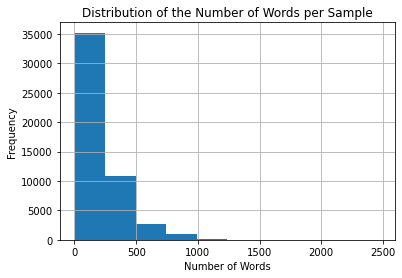

In [ ]:
#Bottom Sources I used for figuring out effective ways to explore the data from the dataset movie_data:

#https://www.geeksforgeeks.org/count-the-number-of-rows-and-columns-of-pandas-dataframe/ 
#https://www.kite.com/python/answers/how-to-count-the-number-of-words-in-a-string-in-python 
#https://www.geeksforgeeks.org/matplotlib-pyplot-hist-in-python/ 
#https://www.geeksforgeeks.org/iterating-over-rows-and-columns-in-pandas-dataframe/ 
#https://realpython.com/python-histograms/ 

#I also received help from my university's teaching assistant Justin Brutger on understanding on why inside the for loop it should be 
#range(len(movie_data['review'])) rather than range(movie_data['review']).
#This is because you can't have a range of anything that is not a float or integer, and the len() function converts the values for movie_data['review'] 
#into floats.


#determines the total number of examples (rows) contained within movie_data
print("Number of Samples: " + str(movie_data.shape[0]))
#determines the total number of categories (columns) contained within movie_data
print("Number of classes: " + str(movie_data.shape[1]))

#using a for loop to add the total number of words contained in each example (row) to a newly created category (column) called "Number_of_Words"
movie_data["Number_of_Words"] = 0
for index in range(len(movie_data['review'])):
  movie_data['Number_of_Words'][index] = len(movie_data['review'][index].split())


 
#determines the median number of words based on the findings for the number of words in each example (row)
print("Number of words per sample: " + str(movie_data['Number_of_Words'].median()))
#creates a histogram displaying the distribution of the number of words in each example (row)
movie_data["Number_of_Words"].hist()
plt.title("Distribution of the Number of Words per Sample")
plt.ylabel("Frequency")
plt.xlabel("Number of Words")





In [ ]:
#checks to see if movie_data has any missing data
movie_data.isna().any()
#no missing data based on the results


review             False
sentiment          False
Number_of_Words    False
dtype: bool

It's important to note that the dataset movie_data contains a total of 50,000 samples, which are contained in a total of 2 classes.  Additionally, I used the median() function to discover the median number words that can be expected in every sample.  I later plotted the distribution of words given all 50,000 samples using a histogram.  Finally, I wanted to see whether the dataset movie_data had any missing data by using the isna().any() functions.  Fortunately, there was no missing data in the dataset movie_data.

In [ ]:
#importing natural language processing libraries
from bs4 import BeautifulSoup 
import re
import nltk
#downloading a list of stopwords from one of the natural language processing libraries that was imported
#stopwords are words that don't have a lot of meaning to them (e.g. the, a, etc.)
nltk.download()
#after being downloaded, the stopwords must be imported from one of the natural language processing libraries
from nltk.corpus import stopwords



NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords
      Package stopwords is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [ ]:
#creating a method where the data from movie_data gets cleaned from punctuation, HTML format, and stopwords, so that
#all the words get converted to lowercase letters to be used
#this is important because text with all lowercase letters is structured in an organized manner that can be used by
#machine learning models (which will be implemented later) to make predictions

def clean_review(review):
    letters_only = re.sub("[^a-zA-Z]"," ",review)
    lower_case = letters_only.lower()
    words = lower_case.split()
    for stop_word in stopwords.words("english"):
        while stop_word in words:
            words.remove(stop_word)
    cleaned = " ".join(words)
    return cleaned

In [ ]:
#using a for loop to apply the above method clean_review to each row in the dataset movie_data,
#and then adding each updated row into a newly created list called cleaned_text
cleaned_text = []
for i in range(len(movie_data)):
    cleaned_text.append(clean_review(movie_data["review"][i]))

In [ ]:
#testing to see whether the list cleaned_text actually contains the updated rows that were intended
cleaned_text[:5]
#based on the results, cleaned_text contains rows with all lowercase letters with no puncutation, HTML format, and stopwords as intended

['one reviewers mentioned watching oz episode hooked right exactly happened br br first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word br br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away br br would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches du

In [ ]:
#declaring and initializing the predictor column, which will be the "review" column since that is what our machine learning models will use to try to make predictions
#based on the target column "sentiment", which is the feedback a user provides for any movie
#train_test_split will also be used to split one part of the data for training and another part of the data for testing
predictor_variable = "review"
target_variable = "sentiment"
train_data, test_data, train_sln, test_sln = \
    train_test_split(movie_data[predictor_variable], movie_data[target_variable], test_size = 0.2, random_state=0)

In [ ]:
#takes in the 500 most common words,and then converts them into a series of numbers to be used as inputs that the machine learning models can use to predict outputs
#additionally, the 500 most common words will have their own separate columns in the dataset movie_data
#the above functionality will be performed by a CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer 


vector = CountVectorizer(analyzer='word', max_features = 500)

vector.fit(train_data)


#the train_data and test_data will be transformed by the CountVectorizer, so they include the new columns that correspond to each of the 500 most common words
train_data_vectors = vector.transform(train_data).toarray()
test_data_vectors = vector.transform(test_data).toarray()

I displayed a confuson matrix of machine learning models that contain almost identical or identical accuracies for every value of the parameter that gets tuned.  A major component of this project is to also determine the optimal machine learning model for determining whether any movie had a positive or negative sentiment.  Specifically, the optimal machine learning model is the model that yields the highest accuracy compared to all the other models.  The reason I will use a confusion matrix rather than other measures of accuracy is because predicting the sentiment towards a movie involves classification as opposed to regression.

I used the Support Vector Machine with a linear function as the kernel, as well as Perceptron and Multilayer Perceptron as my machine learning algorithms.  When implementing the Support Vector Machine, I tuned the regularization constant C.  C is very important to tune, because tuning C will help in the creation of the optimal Support Vector Machine where the data is not overfitted and doesn't have an overgeneralized decision boundary either.  As addressed later, the optimal Support Vector Machine will contain the C that yields the highest accuracy score based on graphical results.  Additionally, Principal Component Analysis will be applied three times using 6, 4, and 2 dimensions on the Support Vector Machine as C gets tuned.

In [ ]:
#Bottom source for understanding the syntax for creating a linear support vector machine:
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html 

#developing a method that creates a linear support vector classifier and then trains the model
#the function prints a confusion matrix associated with each accuracy score of the linear support vector classifier, because almost identical accuracies were generated for the graphs below
#with tuned parameters for the SVC
#the function returns an accuracy score of the linear support vector classifier
def creatingLinearSVC(C, train_data, test_data, train_sln, test_sln):
  support_vector_classifier = LinearSVC(C=C, random_state=0)
  support_vector_classifier.fit(train_data, train_sln)
  support_vector_classifier_prediction = support_vector_classifier.predict(test_data)
  labels = ["negative", "positive"]
  cm = metrics.confusion_matrix(test_sln, support_vector_classifier_prediction, labels=labels)
  print(pandas.DataFrame(cm, index=labels, columns=labels))
  return metrics.accuracy_score(support_vector_classifier_prediction, test_sln)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

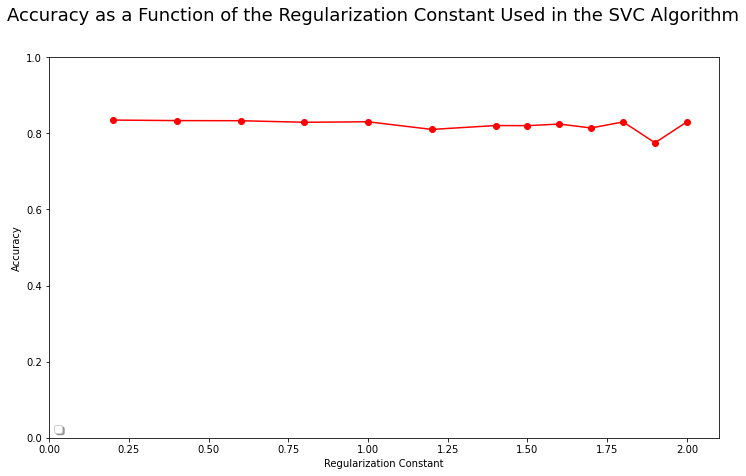

In [ ]:
#declaring and initializing two lists, where the list C_values stores every value that will be used as the regularization constant for the linear support vector classifier;
#the list accuracy_values will store the accuracy that corresponds to each C
%matplotlib inline
C_values = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
accuracy_values = []

#using for loop to append the corresponding accuracy of each C to the list accuracy_values
for C in C_values:
  accuracy = creatingLinearSVC(C, train_data_vectors, test_data_vectors, train_sln, test_sln)
  accuracy_values.append(accuracy)
  
  
  


  
#displays graph that plots the corresponding accuracy of each C
figure_size = plt.figure()
figure_size.set_figwidth(12)
figure_size.set_figheight(7)
plt.suptitle('Accuracy as a Function of the Regularization Constant Used in the SVC Algorithm',fontsize=18)
plt.xlabel('Regularization Constant')
plt.ylabel('Accuracy')
plt.plot(C_values, accuracy_values, 'ro-')
plt.legend(loc='lower left', shadow=True)
plt.axis([0,2.1,0,1])


plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3100      1935
positive      2055      2910


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3099      1936
positive      2055      2910


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3099      1936
positive      2054      2911


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3099      1936
positive      2054      2911


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3098      1937
positive      2053      2912


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3099      1936
positive      2055      2910


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3067      1968
positive      2035      2930


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3101      1934
positive      2054      2911


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3101      1934
positive      2054      2911


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3101      1934
positive      2053      2912


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3099      1936
positive      2053      2912


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3098      1937
positive      2053      2912


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
No handles with labels found to put in legend.


          negative  positive
negative      3093      1942
positive      2044      2921


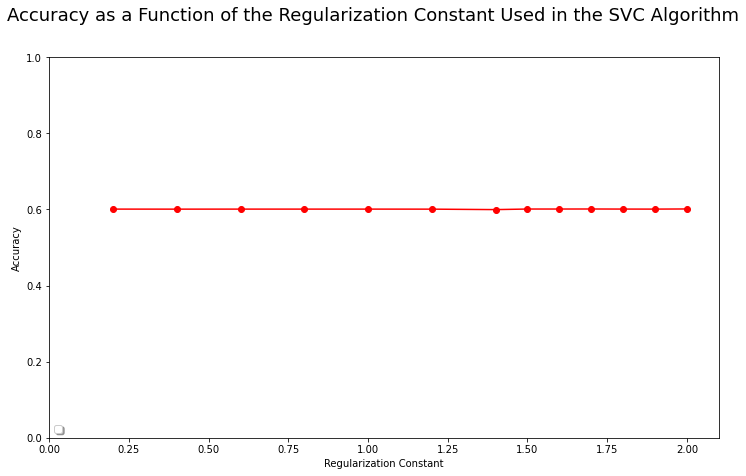

In [ ]:
#declaring and initializing two lists, where the list C_values stores every value that will be used as the regularization constant for the linear support vector classifier;
#the list accuracy_values will store the accuracy that corresponds to each C
#additionally, principal component analysis will be applied on the training and testing data, where the number of dimensions from the dataset movie_data will be reduced to 6
%matplotlib inline
C_values = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
accuracy_values = []
pca = PCA(n_components=6, whiten=True)
pca.fit(train_data_vectors)
new_train_data = pca.transform(train_data_vectors)
new_test_data = pca.transform(test_data_vectors)

#using for loop to append the corresponding accuracy of each C to the list accuracy_values
for C in C_values:
  accuracy = creatingLinearSVC(C, new_train_data, new_test_data, train_sln, test_sln)
  accuracy_values.append(accuracy)
  
  
  
  


  
#displays graph that plots the corresponding accuracy of each C
figure_size = plt.figure()
figure_size.set_figwidth(12)
figure_size.set_figheight(7)
plt.suptitle('Accuracy as a Function of the Regularization Constant Used in the SVC Algorithm',fontsize=18)
plt.xlabel('Regularization Constant')
plt.ylabel('Accuracy')
plt.plot(C_values, accuracy_values, 'ro-')
plt.legend(loc='lower left', shadow=True)
plt.axis([0,2.1,0,1])


plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3042      1993
positive      2047      2918


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3041      1994
positive      2048      2917


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3041      1994
positive      2048      2917


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3040      1995
positive      2047      2918


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3039      1996
positive      2047      2918


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3036      1999
positive      2046      2919


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3039      1996
positive      2046      2919


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3037      1998
positive      2045      2920


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3040      1995
positive      2047      2918


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3037      1998
positive      2045      2920


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3024      2011
positive      2038      2927


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      3036      1999
positive      2046      2919


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
No handles with labels found to put in legend.


          negative  positive
negative      3036      1999
positive      2046      2919


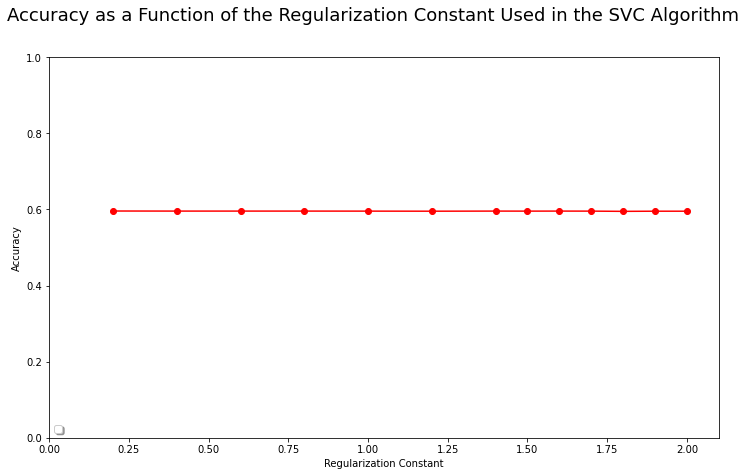

In [ ]:
#declaring and initializing two lists, where the list C_values stores every value that will be used as the regularization constant for the linear support vector classifier;
#the list accuracy_values will store the accuracy that corresponds to each C
#additionally, principal component analysis will be applied on the training and testing data, where the number of dimensions from the dataset movie_data will be reduced to 4
C_values = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
accuracy_values = []
pca = PCA(n_components=4, whiten=True)
pca.fit(train_data_vectors)
new_train_data = pca.transform(train_data_vectors)
new_test_data = pca.transform(test_data_vectors)

#using for loop to append the corresponding accuracy of each C to the list accuracy_values
for C in C_values:
  accuracy = creatingLinearSVC(C, new_train_data, new_test_data, train_sln, test_sln)
  accuracy_values.append(accuracy)
  
  
  


  
#displays graph that plots the corresponding accuracy of each C
figure_size = plt.figure()
figure_size.set_figwidth(12)
figure_size.set_figheight(7)
plt.suptitle('Accuracy as a Function of the Regularization Constant Used in the SVC Algorithm',fontsize=18)
plt.xlabel('Regularization Constant')
plt.ylabel('Accuracy')
plt.plot(C_values, accuracy_values, 'ro-')
plt.legend(loc='lower left', shadow=True)
plt.axis([0,2.1,0,1])


plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      2621      2414
positive      2302      2663


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      2620      2415
positive      2301      2664


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      2619      2416
positive      2299      2666


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      2620      2415
positive      2299      2666


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      2619      2416
positive      2300      2665


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      2619      2416
positive      2300      2665


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      2619      2416
positive      2300      2665


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      2619      2416
positive      2299      2666


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      2618      2417
positive      2296      2669


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      2617      2418
positive      2297      2668


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      2616      2419
positive      2296      2669


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


          negative  positive
negative      2617      2418
positive      2296      2669


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
No handles with labels found to put in legend.


          negative  positive
negative      2618      2417
positive      2296      2669


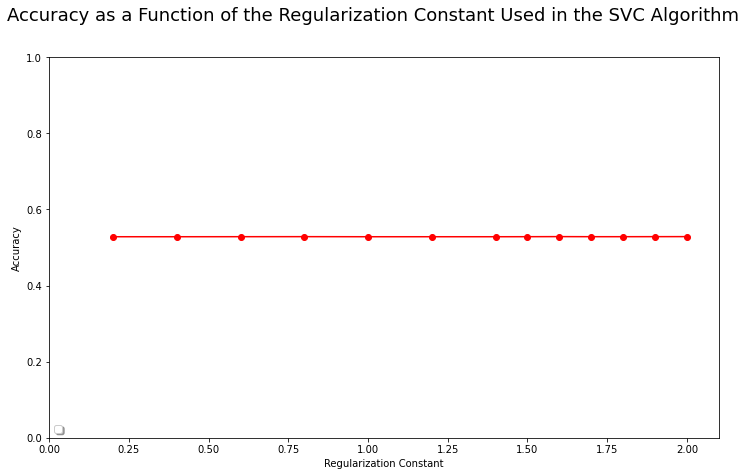

In [ ]:
#declaring and initializing two lists, where the list C_values stores every value that will be used as the regularization constant for the linear support 
#vector classifier;
#the list accuracy_values will store the accuracy that corresponds to each C
#additionally, principal component analysis will be applied on the training and testing data, where the number of dimensions from the dataset movie_data 
#will be reduced to 2
C_values = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
accuracy_values = []
pca = PCA(n_components=2, whiten=True)
pca.fit(train_data_vectors)
new_train_data = pca.transform(train_data_vectors)
new_test_data = pca.transform(test_data_vectors)

#using for loop to append the corresponding accuracy of each C to the list accuracy_values
for C in C_values:
  accuracy = creatingLinearSVC(C, new_train_data, new_test_data, train_sln, test_sln)
  accuracy_values.append(accuracy)
  
  
  


  
#displays graph that plots the corresponding accuracy of each C
figure_size = plt.figure()
figure_size.set_figwidth(12)
figure_size.set_figheight(7)
plt.suptitle('Accuracy as a Function of the Regularization Constant Used in the SVC Algorithm',fontsize=18)
plt.xlabel('Regularization Constant')
plt.ylabel('Accuracy')
plt.plot(C_values, accuracy_values, 'ro-')
plt.legend(loc='lower left', shadow=True)
plt.axis([0,2.1,0,1])


plt.show()

7) I recorded and later organized the graphical results for the Linear SVC from above into a table. The first column of the table specifies the number of dimensions that were used for PCA, if PCA was even used at all (if PCA wasn't used, the number of dimensions was indicated as 0 in the table). The second column indicates the regularization constant that yielded the highest accuracy score on the graph (there were several graphs where the accuracy scores were almost identical or identical, which meant that the regularization constant whose confusion matrix produced somewhere around the highest accuracy score ((TP+TN)/(TP+TN+FP+FN)) compared to other confusion matrices would be indicated in the second column). Finally, the last column indicates the highest accuracy score that was yielded by the regularization constant from the second column. After having analyzed the data that I organized into a table, the optimal Linear SVC is the model that has no PCA applied with a regularization constant of 1.8.
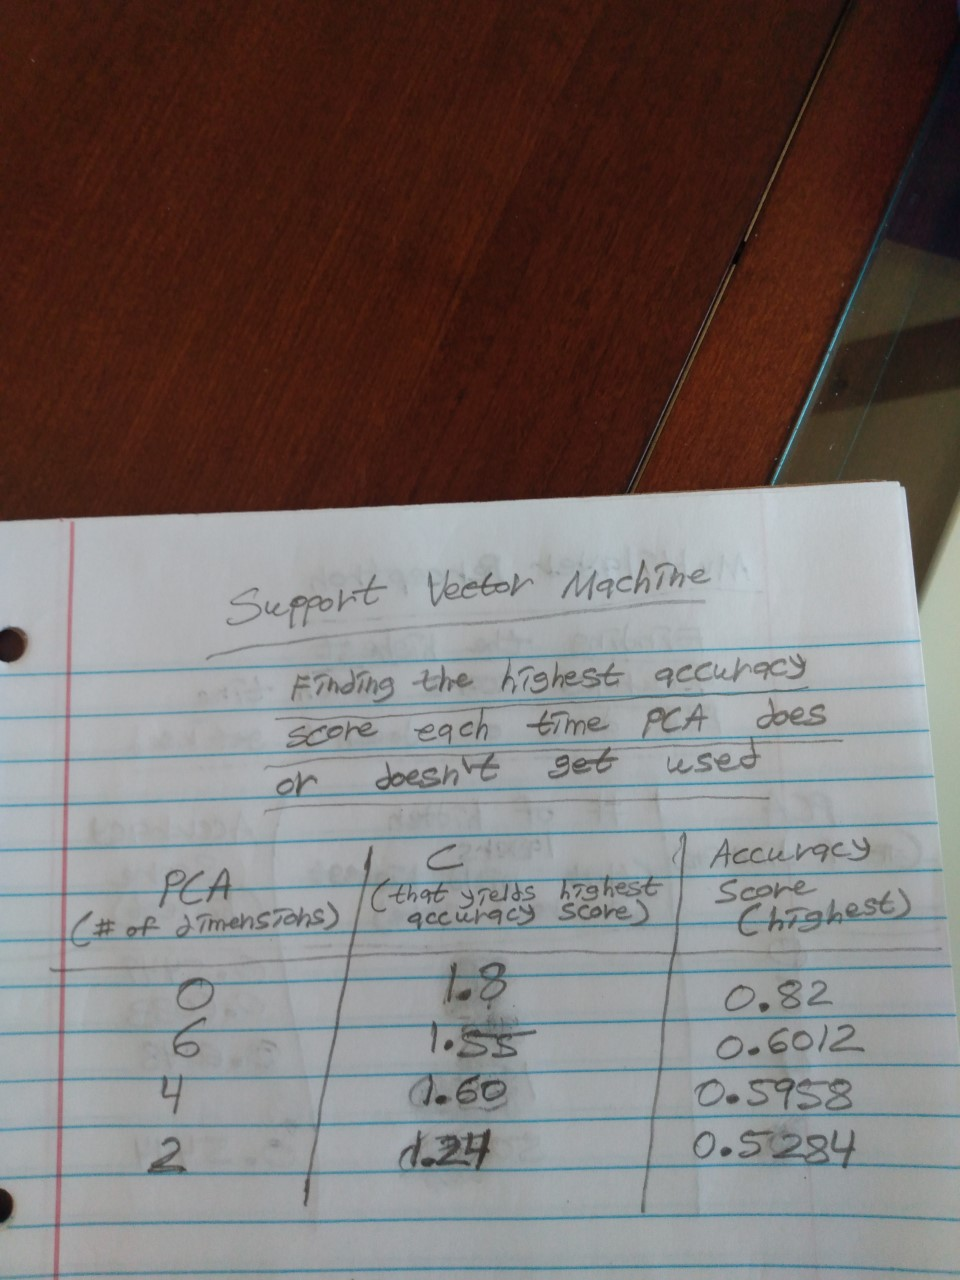

When implementing the Perceptron, I tuned the learning rate eta0 (which is given the name "eta" specifically in this experiment).  The learning rate eta represents how long the Perceptron must train and learn, so that it's able to adapt to its methodology when it comes to making predictions.  The goal is to have the Perceptron that trains and learns for several epochs but doesn't take too long to learn where its predictions are not consistent with the inputs and data that are provided.  The Perceptron that aligns with this goal will be the one which contains eta that yields the highest accuracy score, based on the results from the graphs that will be created later in the experiment.  Additionally, Principal Component Analysis will be applied three times using 6, 4, and 2 dimensions on the Perceptron as eta gets tuned.

In [ ]:
#developing a method that creates a perceptron and then trains the model
#the function returns an accuracy score of the perceptron
def creatingPerceptron(eta, train_data, test_data, train_sln, test_sln):
  perceptron = Perceptron(random_state=0, eta0=eta)
  perceptron.fit(train_data, train_sln)
  perceptron_prediction = perceptron.predict(test_data)
  labels = ["negative", "positive"]
  cm = metrics.confusion_matrix(test_sln, perceptron_prediction, labels=labels)
  print(pandas.DataFrame(cm, index=labels, columns=labels))
  return metrics.accuracy_score(perceptron_prediction, test_sln)

No handles with labels found to put in legend.


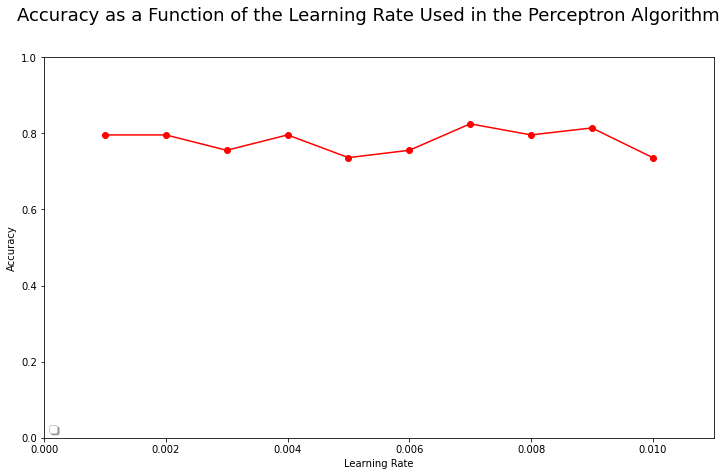

In [ ]:
#declaring and initializing two lists, where the list eta_values stores every value that will be used as the learning rate for the perceptron;
#the list accuracy_values will store the accuracy that corresponds to each eta
%matplotlib inline
eta_values = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
accuracy_values = []

#using for loop to append the corresponding accuracy of each eta to the list accuracy_values
for eta in eta_values:
  accuracy = creatingPerceptron(eta, train_data_vectors, test_data_vectors, train_sln, test_sln)
  accuracy_values.append(accuracy)
  
  
  


  
#displays graph that plots the corresponding accuracy of each eta
figure_size = plt.figure()
figure_size.set_figwidth(12)
figure_size.set_figheight(7)
plt.suptitle('Accuracy as a Function of the Learning Rate Used in the Perceptron Algorithm',fontsize=18)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.plot(eta_values, accuracy_values, 'ro-')
plt.legend(loc='lower left', shadow=True)
plt.axis([0,0.011,0,1])


plt.show()

          negative  positive
negative      2950      2085
positive      2227      2738
          negative  positive
negative      2950      2085
positive      2227      2738
          negative  positive
negative      2950      2085
positive      2227      2738
          negative  positive
negative      2950      2085
positive      2227      2738
          negative  positive
negative      2950      2085
positive      2227      2738
          negative  positive
negative      2950      2085
positive      2227      2738
          negative  positive
negative      2950      2085
positive      2227      2738
          negative  positive
negative      2950      2085
positive      2227      2738
          negative  positive
negative      2950      2085
positive      2227      2738
          negative  positive
negative      2950      2085
positive      2227      2738


No handles with labels found to put in legend.


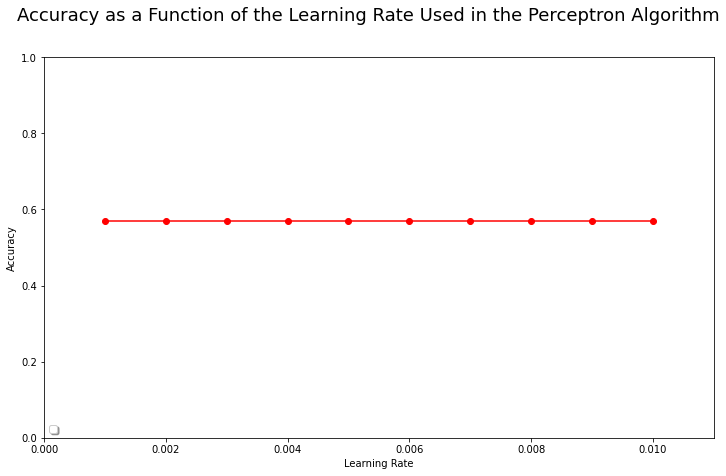

In [ ]:
#declaring and initializing two lists, where the list eta_values stores every value that will be used as the learning rate for the perceptron;
#the list accuracy_values will store the accuracy that corresponds to each eta
#additionally, principal component analysis will be applied on the training and testing data, where the number of dimensions from the dataset movie_data will 
#be reduced to 6
%matplotlib inline
eta_values = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
accuracy_values = []
pca = PCA(n_components=6, whiten=True)
pca.fit(train_data_vectors)
new_train_data = pca.transform(train_data_vectors)
new_test_data = pca.transform(test_data_vectors)

#using for loop to append the corresponding accuracy of each eta to the list accuracy_values
for eta in eta_values:
  accuracy = creatingPerceptron(eta, new_train_data, new_test_data, train_sln, test_sln)
  accuracy_values.append(accuracy)
  
  
  


  
#displays graph that plots the corresponding accuracy of each eta
figure_size = plt.figure()
figure_size.set_figwidth(12)
figure_size.set_figheight(7)
plt.suptitle('Accuracy as a Function of the Learning Rate Used in the Perceptron Algorithm',fontsize=18)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.plot(eta_values, accuracy_values, 'ro-')
plt.legend(loc='lower left', shadow=True)
plt.axis([0,0.011,0,1])


plt.show()

          negative  positive
negative      3886      1149
positive      3265      1700
          negative  positive
negative      3886      1149
positive      3265      1700
          negative  positive
negative      3886      1149
positive      3265      1700
          negative  positive
negative      3886      1149
positive      3265      1700
          negative  positive
negative      3886      1149
positive      3265      1700
          negative  positive
negative      3886      1149
positive      3265      1700
          negative  positive
negative      3886      1149
positive      3265      1700
          negative  positive
negative      3886      1149
positive      3265      1700
          negative  positive
negative      3886      1149
positive      3265      1700
          negative  positive
negative      3886      1149
positive      3265      1700


No handles with labels found to put in legend.


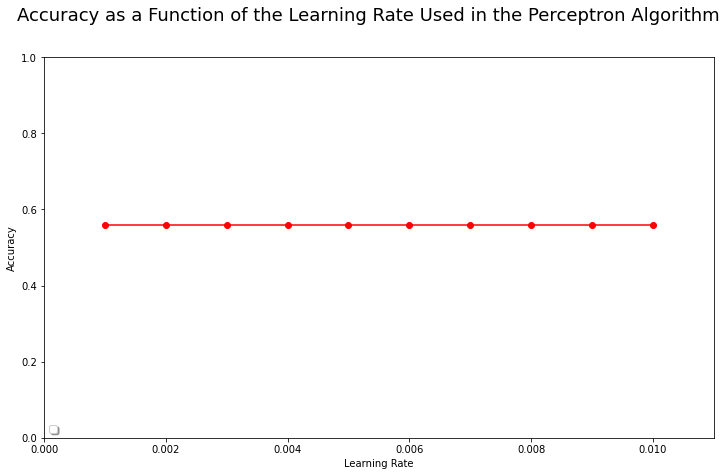

In [ ]:
#declaring and initializing two lists, where the list eta_values stores every value that will be used as the learning rate for the perceptron;
#the list accuracy_values will store the accuracy that corresponds to each eta
#additionally, principal component analysis will be applied on the training and testing data, where the number of dimensions from the dataset movie_data 
#will be reduced to 4
%matplotlib inline
eta_values = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
accuracy_values = []
pca = PCA(n_components=4, whiten=True)
pca.fit(train_data_vectors)
new_train_data = pca.transform(train_data_vectors)
new_test_data = pca.transform(test_data_vectors)

#using for loop to append the corresponding accuracy of each eta to the list accuracy_values
for eta in eta_values:
  accuracy = creatingPerceptron(eta, new_train_data, new_test_data, train_sln, test_sln)
  accuracy_values.append(accuracy)
  
  
  


  
#displays graph that plots the corresponding accuracy of each eta
figure_size = plt.figure()
figure_size.set_figwidth(12)
figure_size.set_figheight(7)
plt.suptitle('Accuracy as a Function of the Learning Rate Used in the Perceptron Algorithm',fontsize=18)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.plot(eta_values, accuracy_values, 'ro-')
plt.legend(loc='lower left', shadow=True)
plt.axis([0,0.011,0,1])


plt.show()

          negative  positive
negative      4895       140
positive      4791       174
          negative  positive
negative      4895       140
positive      4791       174
          negative  positive
negative      4895       140
positive      4791       174
          negative  positive
negative      4895       140
positive      4791       174
          negative  positive
negative      4895       140
positive      4791       174
          negative  positive
negative      4895       140
positive      4791       174
          negative  positive
negative      4895       140
positive      4791       174
          negative  positive
negative      4895       140
positive      4791       174
          negative  positive
negative      4895       140
positive      4791       174
          negative  positive
negative      4895       140
positive      4791       174


No handles with labels found to put in legend.


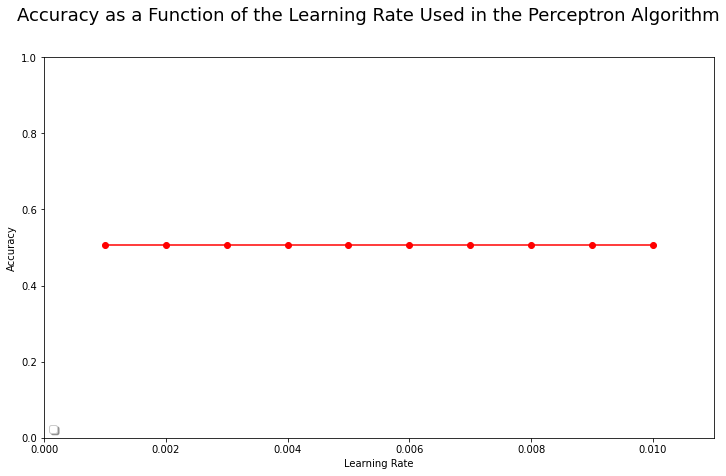

In [ ]:
#declaring and initializing two lists, where the list eta_values stores every value that will be used as the learning rate for the perceptron;
#the list accuracy_values will store the accuracy that corresponds to each eta
#additionally, principal component analysis will be applied on the training and testing data, where the number of dimensions from the dataset movie_data 
#will be reduced to 2
%matplotlib inline
eta_values = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
accuracy_values = []
pca = PCA(n_components=2, whiten=True)
pca.fit(train_data_vectors)
new_train_data = pca.transform(train_data_vectors)
new_test_data = pca.transform(test_data_vectors)

#using for loop to append the corresponding accuracy of each eta to the list accuracy_values
for eta in eta_values:
  accuracy = creatingPerceptron(eta, new_train_data, new_test_data, train_sln, test_sln)
  accuracy_values.append(accuracy)
  
  
  


  
#displays graph that plots the corresponding accuracy of each eta
figure_size = plt.figure()
figure_size.set_figwidth(12)
figure_size.set_figheight(7)
plt.suptitle('Accuracy as a Function of the Learning Rate Used in the Perceptron Algorithm',fontsize=18)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.plot(eta_values, accuracy_values, 'ro-')
plt.legend(loc='lower left', shadow=True)
plt.axis([0,0.011,0,1])


plt.show()

7) I recorded and later organized the graphical results for the Perceptron from above into a table. The first column of the table specifies the number of dimensions that were used for PCA, if PCA was even used at all (if PCA wasn't used, the number of dimensions was indicated as 0 in the table). The second column indicates the learning rate that yielded the highest accuracy score on the graph (there were several graphs where the accuracy scores were almost identical or identical, which meant that the learning rate whose confusion matrix produced somewhere around the highest accuracy score ((TP+TN)/(TP+TN+FP+FN)) compared to other confusion matrices would be indicated in the second column). Finally, the last column indicates the highest accuracy score that was yielded by the learning rate from the second column. After having analyzed the data that I organized into a table, the optimal Perceptron is the model that has no PCA applied with a learning rate of 0.007.
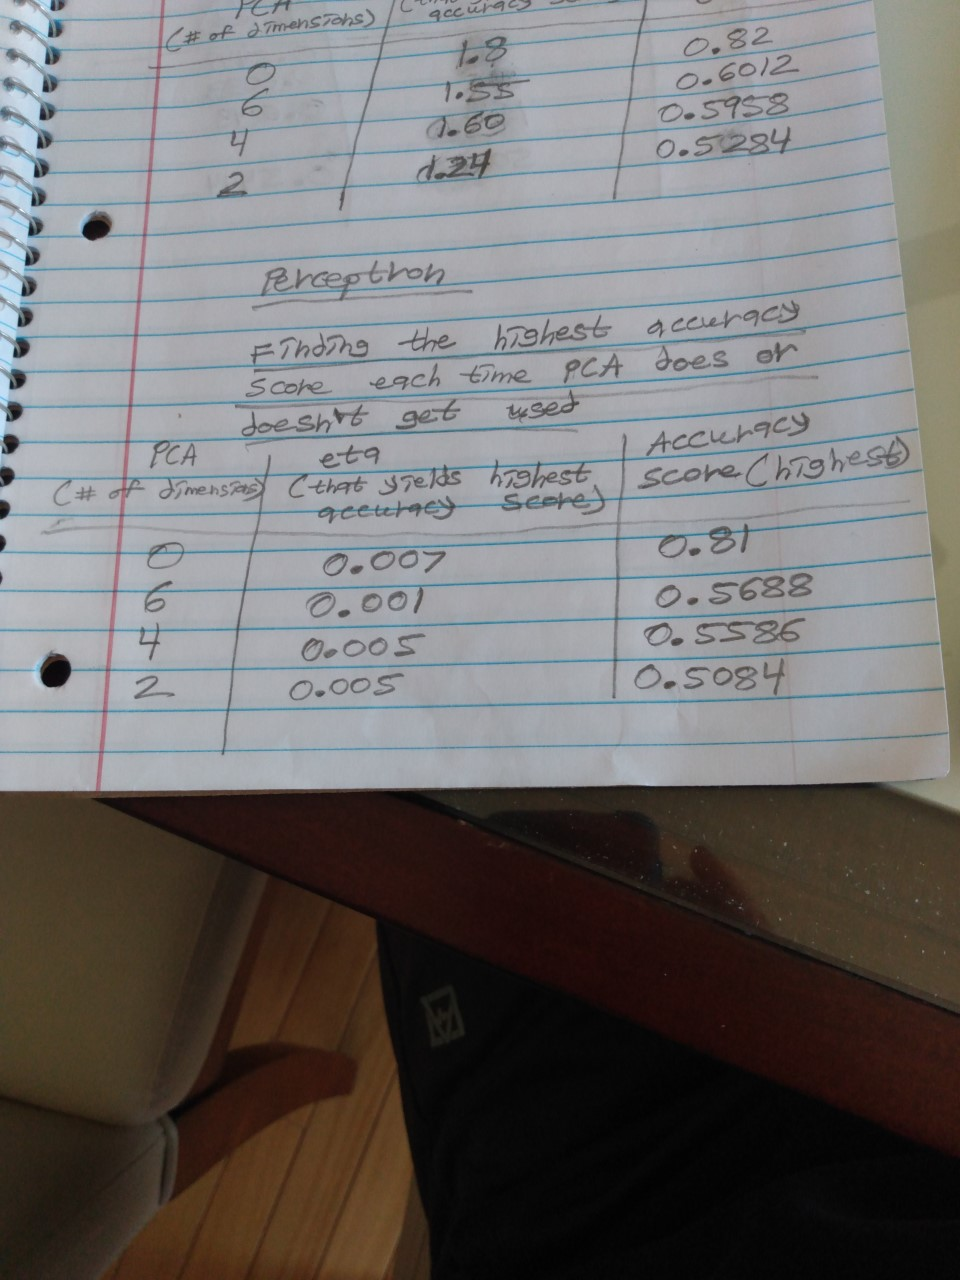

When implementing the Multilayer Perceptron, I tuned the number of hidden layers contained within the Multilayer Perceptron's structure.  By tuning the number of hidden layers, I hoped to discover in my experiment whether having less or more hidden layers helps the Multilayer Perceptron be more consistent with its outputs based on the inputs the model receives.  Ultimately, whether it's best to have fewer or more hidden layers can be measured by the accuracy score of using the Multilayer Perceptron with a certain number of layers.  The optimal Multilayer Perceptron will be the model with the number of hidden layers that yields the highest accuracy score, based on the results from the graphs that will be displayed later in the experiment.  Additionally, Principal Component Analysis will be applied three times using 6, 4, and 2 dimensions on the Multilayer Perceptron as the number of hidden layers gets tuned.

In [ ]:
#Bottom source for understanding the syntax for creating a multilayer perceptron:
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html 

#developing a method that creates a multilayer perceptron and then trains the model
#the function returns an accuracy score of the multilayer perceptron

def creatingMultilayerPerceptron(number_of_hidden_layers, train_data, test_data, train_sln, test_sln):
  ann = MLPClassifier(hidden_layer_sizes=number_of_hidden_layers, random_state=0)
  ann.fit(train_data, train_sln)
  ann_prediction = ann.predict(test_data)
  labels = ["negative", "positive"]
  cm = metrics.confusion_matrix(test_sln, ann_prediction, labels=labels)
  print(pandas.DataFrame(cm, index=labels, columns=labels))
  return metrics.accuracy_score(ann_prediction, test_sln)

          negative  positive
negative      3258      1777
positive      2774      2191
          negative  positive
negative      3644      1391
positive      3218      1747
          negative  positive
negative      3393      1642
positive      2930      2035


No handles with labels found to put in legend.


          negative  positive
negative      3274      1761
positive      2830      2135


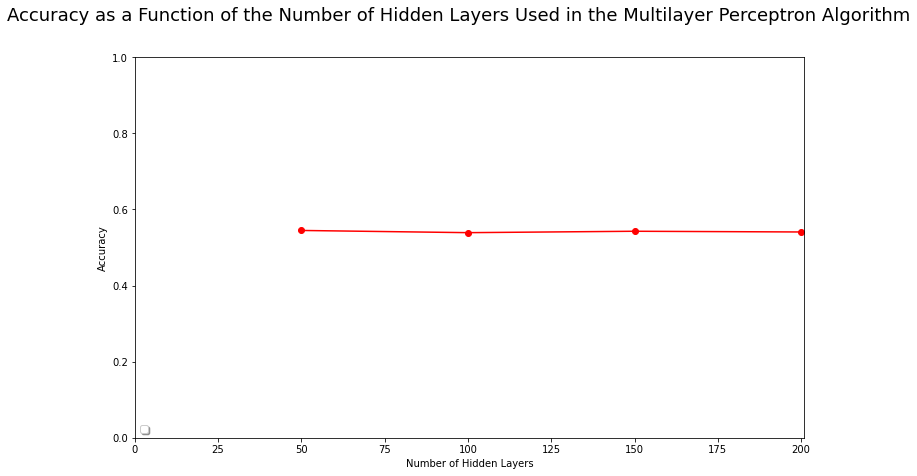

In [ ]:
#declaring and initializing two lists, where the list hidden_layer_values stores every value that will be used as the number of hidden layers for the 
#multilayer perceptron;
#the list accuracy_values will store the accuracy that corresponds to each hidden layer

%matplotlib inline
hidden_layer_values = [50, 100, 150, 200]
accuracy_values = []

#using for loop to append the corresponding accuracy of each hidden layer to the list accuracy_values
for hidden_layer in hidden_layer_values:
  accuracy = creatingMultilayerPerceptron(hidden_layer, new_train_data, new_test_data, train_sln, test_sln)
  accuracy_values.append(accuracy)
  
  
  


  
#displays graph that plots the corresponding accuracy of each hidden layer
figure_size = plt.figure()
figure_size.set_figwidth(12)
figure_size.set_figheight(7)
plt.suptitle('Accuracy as a Function of the Number of Hidden Layers Used in the Multilayer Perceptron Algorithm',fontsize=18)
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.plot(hidden_layer_values, accuracy_values, 'ro-')
plt.legend(loc='lower left', shadow=True)
plt.axis([0,201,0,1])


plt.show()

          negative  positive
negative      3141      1894
positive      2023      2942
          negative  positive
negative      3064      1971
positive      1987      2978
          negative  positive
negative      3077      1958
positive      2023      2942


No handles with labels found to put in legend.


          negative  positive
negative      3042      1993
positive      1967      2998


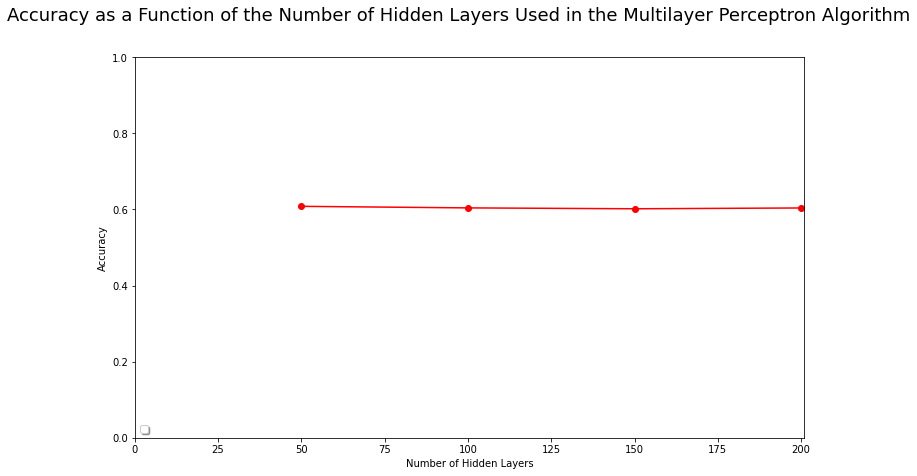

In [ ]:
#declaring and initializing two lists, where the list hidden_layer_values stores every value that will be used as the number of hidden layers for the 
#multilayer perceptron;
#the list accuracy_values will store the accuracy that corresponds to each hidden layer
#additionally, principal component analysis will be applied on the training and testing data, where the number of dimensions from the dataset movie_data 
#will be reduced to 6
%matplotlib inline
hidden_layer_values = [50, 100, 150, 200]
accuracy_values = []
pca = PCA(n_components=6, whiten=True)
pca.fit(train_data_vectors)
new_train_data = pca.transform(train_data_vectors)
new_test_data = pca.transform(test_data_vectors)

#using for loop to append the corresponding accuracy of each hidden layer to the list accuracy_values
for hidden_layer in hidden_layer_values:
  accuracy = creatingMultilayerPerceptron(hidden_layer, new_train_data, new_test_data, train_sln, test_sln)
  accuracy_values.append(accuracy)
  
  
  


  
#displays graph that plots the corresponding accuracy of each hidden layer
figure_size = plt.figure()
figure_size.set_figwidth(12)
figure_size.set_figheight(7)
plt.suptitle('Accuracy as a Function of the Number of Hidden Layers Used in the Multilayer Perceptron Algorithm',fontsize=18)
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.plot(hidden_layer_values, accuracy_values, 'ro-')
plt.legend(loc='lower left', shadow=True)
plt.axis([0,201,0,1])


plt.show()

          negative  positive
negative      3175      1860
positive      2175      2790
          negative  positive
negative      3124      1911
positive      2092      2873
          negative  positive
negative      3257      1778
positive      2174      2791


No handles with labels found to put in legend.


          negative  positive
negative      3208      1827
positive      2157      2808


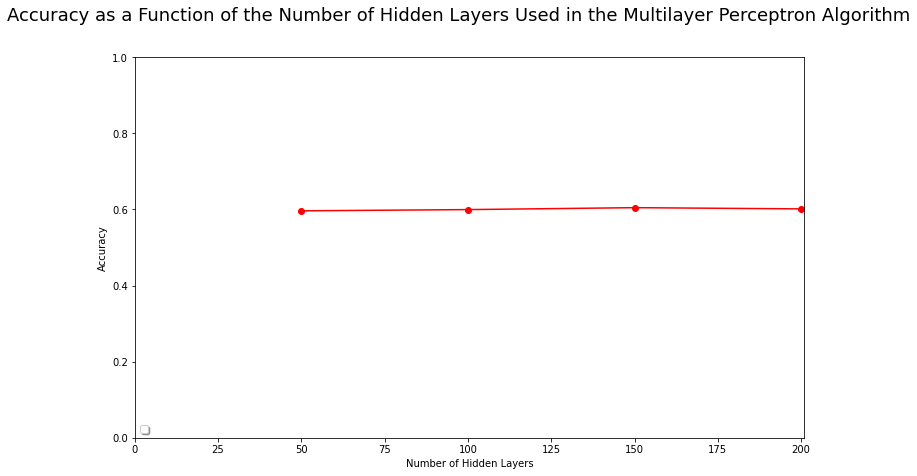

In [ ]:
#declaring and initializing two lists, where the list hidden_layer_values stores every value that will be used as the number of hidden layers for the 
#multilayer perceptron;
#the list accuracy_values will store the accuracy that corresponds to each hidden layer
#additionally, principal component analysis will be applied on the training and testing data, where the number of dimensions from the dataset movie_data 
#will be reduced to 4
%matplotlib inline
hidden_layer_values = [50, 100, 150, 200]
accuracy_values = []
pca = PCA(n_components=4, whiten=True)
pca.fit(train_data_vectors)
new_train_data = pca.transform(train_data_vectors)
new_test_data = pca.transform(test_data_vectors)

#using for loop to append the corresponding accuracy of each hidden layer to the list accuracy_values
for hidden_layer in hidden_layer_values:
  accuracy = creatingMultilayerPerceptron(hidden_layer, new_train_data, new_test_data, train_sln, test_sln)
  accuracy_values.append(accuracy)
  
  
  


  
#displays graph that plots the corresponding accuracy of each hidden layer
figure_size = plt.figure()
figure_size.set_figwidth(12)
figure_size.set_figheight(7)
plt.suptitle('Accuracy as a Function of the Number of Hidden Layers Used in the Multilayer Perceptron Algorithm',fontsize=18)
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.plot(hidden_layer_values, accuracy_values, 'ro-')
plt.legend(loc='lower left', shadow=True)
plt.axis([0,201,0,1])


plt.show()

          negative  positive
negative      3256      1779
positive      2777      2188
          negative  positive
negative      3639      1396
positive      3223      1742
          negative  positive
negative      3392      1643
positive      2932      2033


No handles with labels found to put in legend.


          negative  positive
negative      3277      1758
positive      2836      2129


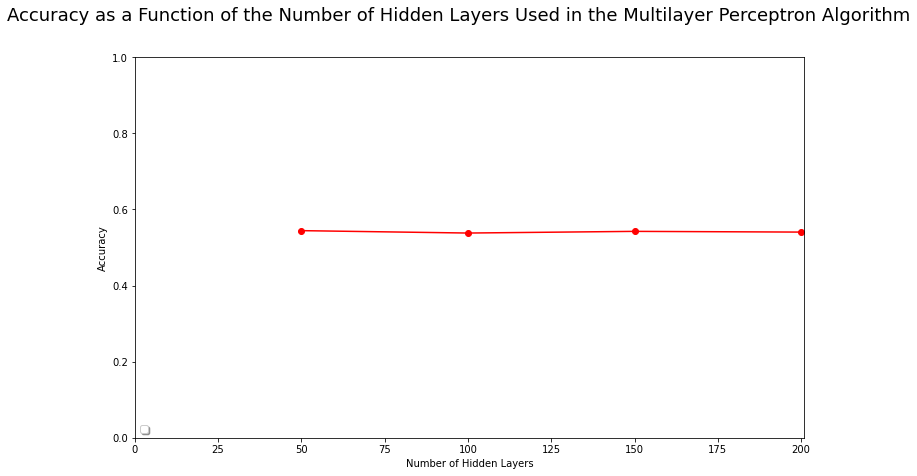

In [ ]:
#declaring and initializing two lists, where the list hidden_layer_values stores every value that will be used as the number of hidden layers for the 
#multilayer perceptron;
#the list accuracy_values will store the accuracy that corresponds to each hidden layer
#additionally, principal component analysis will be applied on the training and testing data, where the number of dimensions from the dataset movie_data 
#will be reduced to 2
%matplotlib inline
hidden_layer_values = [50, 100, 150, 200]
accuracy_values = []
pca = PCA(n_components=2, whiten=True)
pca.fit(train_data_vectors)
new_train_data = pca.transform(train_data_vectors)
new_test_data = pca.transform(test_data_vectors)

#using for loop to append the corresponding accuracy of each hidden layer to the list accuracy_values
for hidden_layer in hidden_layer_values:
  accuracy = creatingMultilayerPerceptron(hidden_layer, new_train_data, new_test_data, train_sln, test_sln)
  accuracy_values.append(accuracy)
  
  
  


  
#displays graph that plots the corresponding accuracy of each hidden layer
figure_size = plt.figure()
figure_size.set_figwidth(12)
figure_size.set_figheight(7)
plt.suptitle('Accuracy as a Function of the Number of Hidden Layers Used in the Multilayer Perceptron Algorithm',fontsize=18)
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.plot(hidden_layer_values, accuracy_values, 'ro-')
plt.legend(loc='lower left', shadow=True)
plt.axis([0,201,0,1])


plt.show()

7) I recorded and later organized the graphical results for the Multilayer Perceptron from above into a table. The first column of the table specifies the number of dimensions that were used for PCA, if PCA was even used at all (if PCA wasn't used, the number of dimensions was indicated as 0 in the table). The second column indicates the number of hidden layers that yielded the highest accuracy score on the graph (there were several graphs where the accuracy scores were almost identical or identical, which meant that the number of hidden layers whose confusion matrix produced somewhere around the highest accuracy score ((TP+TN)/(TP+TN+FP+FN)) compared to other confusion matrices would be indicated in the second column). Finally, the last column indicates the highest accuracy score that was yielded by the number of hidden layers from the second column. After having analyzed the data that I organized into a table, the optimal Multilayer Perceptron is the model that has 50 hidden layers and PCA applied with 6 dimensions.
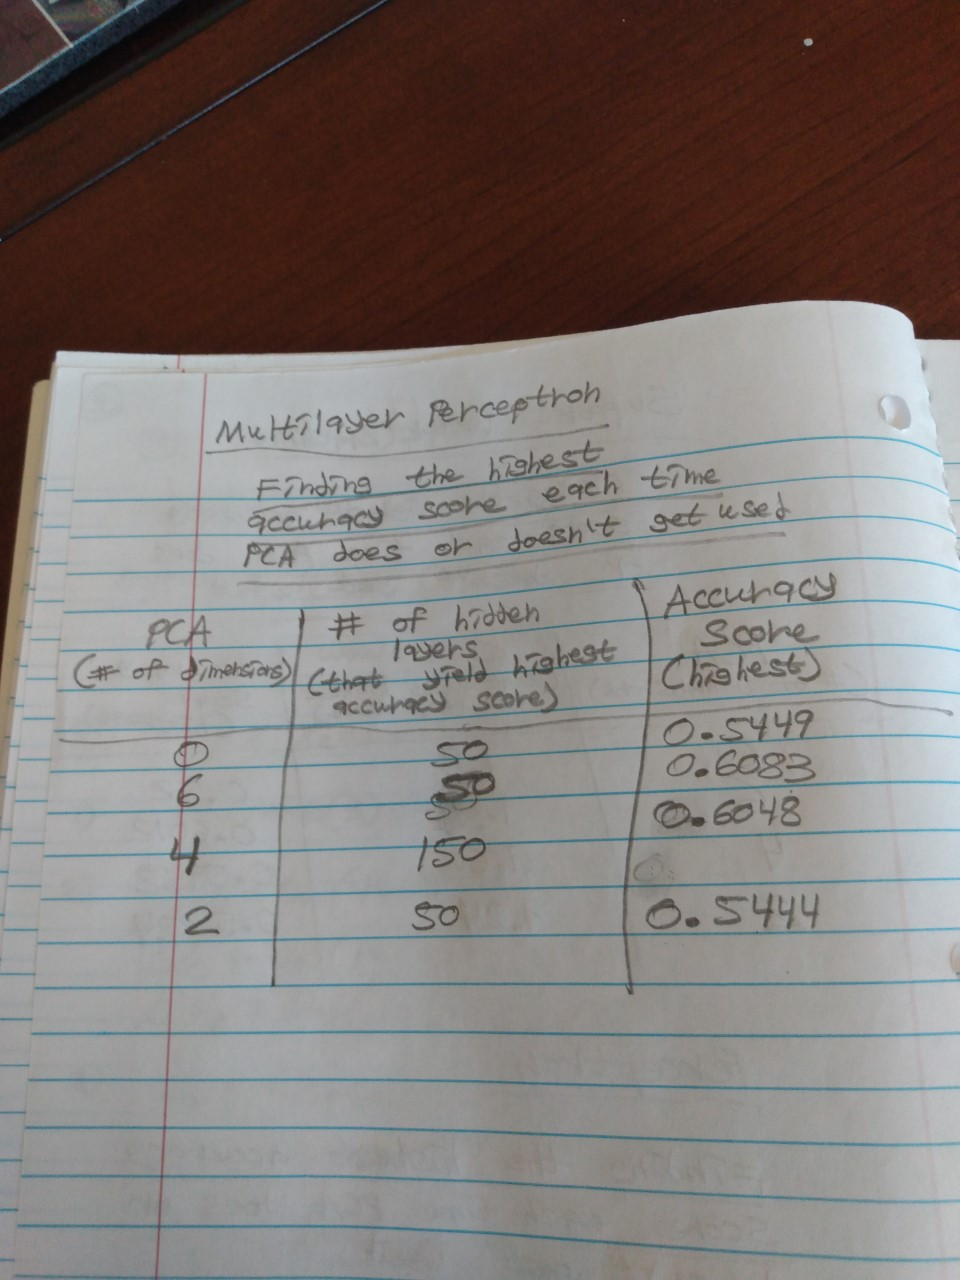

The Linear Support Vector Classifier with a regularization constant of 1.8 and no PCA used was the best model, because the highest accuracy score the model yielded was greater than the highest accuracy scores all the other models yielded.  Interestingly, the Linear Support Vector Classifier (with a regularization constant of 1.8 and no PCA used) yielded an accuracy score of 0.82, which was a litle higher than the Perceptron's (with a learning rate of 0.007 and no PCA used) highest accuracy of 0.81, but a lot higher than the Multilayer Perceptron's (with 50 hidden layers and PCA with 6 dimensions) highest accuracy of 0.6083.  Ultimately, this goes to show that a simple model that doesn't include many steps towards making a prediction would be the best way to predict a user's movie sentiment towards any movie.  This can be further explained when looking at the fact that the optimal Multilayer Perceptron was the one that used the fewest number of hidden layers in the experiment, and more hidden layers are typically of necessity when the problems become more complex where it becomes ever the more important for the Multilayer Perceptron to store previous knowledge that may be key towards making a prediction.  In the case of predicting movie sentiment, no previous knowledge must be stored, as the feedback the user provides in the column "review" is only necessary for predicting whether any movie received a positive or negative movie sentiment.  Since it's easy to create the margins that require predicting either a positive or negative sentiment, it makes sense for why a Support Vector Machine as opposed to a Perceptron would be a better machine learning algorithm in this case.

In [ ]:
#importing the necessary libraries for the RNN to be used for natural language processing
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

In [ ]:
#Checking Tensor Flow version
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    !pip install -q -U transformers
    IS_COLAB = True
except Exception:
    IS_COLAB = False

     |████████████████████████████████| 706kB 7.6MB/s 
     |████████████████████████████████| 2.1MB 8.4MB/s 
     |████████████████████████████████| 901kB 49.9MB/s 
     |████████████████████████████████| 3.3MB 48.2MB/s 


In [ ]:
#importing Tensor Flow
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"



In [ ]:
#importing more libraries
import numpy as np
import os

In [ ]:
#deciding on the size of dataset to be used for natural language processing
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Bottom source for recognizing the importance of a for loop when using the function lower():
#https://www.kaggle.com/questions-and-answers/188052 

#using for loop to make the text lower case from the column "review"
for index in range(len(movie_data["review"])):
  "".join(sorted(set(movie_data["review"][index].lower())))

In [ ]:
#Bottom source for understanding the parameters of a Tokenizer:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

#creating a Tokenizer to create a word-level language model by specifying the parameter char_level as False
tokenizer = keras.preprocessing.text.Tokenizer(char_level=False)
tokenizer.fit_on_texts(movie_data["review"])

In [ ]:
#checking to see which number corresponds to the word "production"
tokenizer.texts_to_sequences(["production"])

[[353]]

In [ ]:
#verfying whether the word "production" corresponds to the same number as above
tokenizer.sequences_to_texts([[353]])

['production']

In [ ]:
#preparing the dataset movie_data to be used for natural language processing
max_unique_words = len(tokenizer.word_index) #total number of distinct words
max_words = tokenizer.document_count # total number of all words
for index in range(len(movie_data["review"])):
  [encoded] = np.array(tokenizer.texts_to_sequences([movie_data["review"][index]])) - 1
train_data_size = max_words * 90 // 100
movie_dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_data_size])

n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
movie_dataset = movie_dataset.repeat().window(window_length, shift=1, drop_remainder=True)

movie_dataset = movie_dataset.flat_map(lambda window: window.batch(window_length))

np.random.seed(42)
tf.random.set_seed(42)

batch_size = 32
movie_dataset = movie_dataset.shuffle(10000).batch(batch_size)
movie_dataset = movie_dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

movie_dataset = movie_dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_unique_words), Y_batch))

movie_dataset = movie_dataset.prefetch(1)


for X_batch, Y_batch in movie_dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 124252) (32, 100)


In [ ]:
#implementing an RNN model as a word-level language model to be used for NLP
#the model will train for 6 epochs
model = keras.models.Sequential([
    keras.layers.GRU(64, return_sequences=True, input_shape=[None, max_unique_words],
                     dropout=0.2),
    keras.layers.GRU(64, return_sequences=True,
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_unique_words,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(movie_dataset, steps_per_epoch=train_data_size // batch_size,
                    epochs=6)

Epoch 1/6
1406/1406 [==============================] - 1492s 1s/step - loss: 5.1842
Epoch 2/6
1406/1406 [==============================] - 1479s 1s/step - loss: 4.2110
Epoch 3/6
1406/1406 [==============================] - 1482s 1s/step - loss: 4.2112
Epoch 4/6
1406/1406 [==============================] - 1477s 1s/step - loss: 4.2111
Epoch 5/6
1406/1406 [==============================] - 1478s 1s/step - loss: 4.1604
Epoch 6/6
1406/1406 [==============================] - 1488s 1s/step - loss: 0.3023


In [ ]:
#creating a helper method to be used for the bottom next_word method
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_unique_words)

In [ ]:
#creating a function that predicts the next word in a piece of text
def next_word(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())

In [ ]:
#testing the above function
tf.random.set_seed(42)

next_word("What can I do for", temperature=1)

['the']

In [ ]:
#testing the above function
next_word("How are you", temperature=1)

['far']